# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import keras
import tensorflow as tf
import cv2

Using TensorFlow backend.


# Loading datasets

In [ ]:
images = os.path.join('/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images')
annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
train=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))
submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))

# Visualize datasets

In [ ]:
print(train.shape)
train.head()

(15412, 6)


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [ ]:
print('we have {} number of classes.'.format(train.classname.nunique()))
print(train.classname.unique())

we have 20 number of classes.
['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


In [ ]:
# as we need only faces with mask and without mask
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

<BarContainer object of 2 artists>

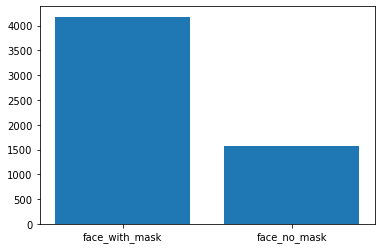

In [ ]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

In [ ]:
print('We are having {} images in the Dataset.'.format(len(os.listdir(images))))

We are having 6024 images in the Dataset.


In [ ]:
a = os.listdir(images)
b = os.listdir(annotations)

a.sort()
b.sort()

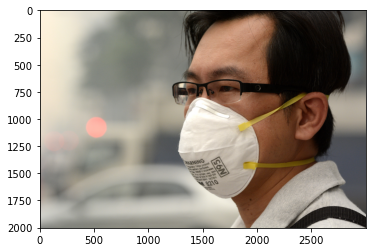

In [ ]:
img=plt.imread(os.path.join(images,a[2]))
plt.imshow(img)
plt.show()

In [ ]:
bbox = []
for i in range(len(train)):
    arr = []
    for j in train.iloc[i][['x1','x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train['bbox'] = bbox

In [ ]:
def get_boxes(id):
    boxes = []
    for i in train[train['name']==str(id)]['bbox']:
        boxes.append(i)
    return boxes

In [ ]:
image_id = [i for i in train.name]

[[451, 186, 895, 697]]


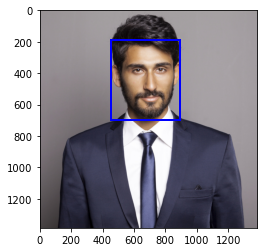

In [ ]:
print(get_boxes(image_id[0]))
image = image_id[0]
img = plt.imread(os.path.join(images, image))
fig, ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
plt.show()

# Creating Training Data

In [ ]:
img_size = 50
data = []
path='/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/'

In [ ]:
for i in range(len(train)):
    arr = []
    for j in train.iloc[i]:
        arr.append(j)
    img_array = cv2.imread(os.path.join(images, arr[0]), cv2.IMREAD_GRAYSCALE)
    crop_image = img_array[arr[2]:arr[4], arr[1]:arr[3]]
    new_img_array = cv2.resize(crop_image, (img_size, img_size))
    data.append([new_img_array, arr[5]])

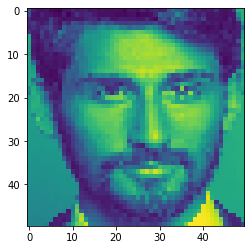

In [ ]:
plt.imshow(data[0][0])

In [ ]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [ ]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

In [ ]:
lbl.classes_

array(['face_no_mask', 'face_with_mask'], dtype='<U14')

In [ ]:
# split in train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Model Fitting

In [ ]:
#pip install mtcnn

     |████████████████████████████████| 2.3 MB 3.5 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from mtcnn.mtcnn import MTCNN

In [ ]:
model = keras.models.Sequential([
    Conv2D(100, (3,3), input_shape=x.shape[1:], activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    
    Dense(2, activation='softmax')
])

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train,y_train,epochs=30,batch_size=5)

Epoch 1/30
920/920 [==============================] - 3s 3ms/step - loss: 0.5628 - accuracy: 0.7271
Epoch 2/30
920/920 [==============================] - 3s 3ms/step - loss: 0.4775 - accuracy: 0.7743
Epoch 3/30
920/920 [==============================] - 3s 3ms/step - loss: 0.4255 - accuracy: 0.7989
Epoch 4/30
920/920 [==============================] - 3s 3ms/step - loss: 0.3859 - accuracy: 0.8169
Epoch 5/30
920/920 [==============================] - 3s 3ms/step - loss: 0.3557 - accuracy: 0.8428
Epoch 6/30
920/920 [==============================] - 4s 4ms/step - loss: 0.3311 - accuracy: 0.8534
Epoch 7/30
920/920 [==============================] - 3s 3ms/step - loss: 0.2892 - accuracy: 0.8687
Epoch 8/30
920/920 [==============================] - 3s 3ms/step - loss: 0.2667 - accuracy: 0.8839
Epoch 9/30
920/920 [==============================] - 3s 3ms/step - loss: 0.2321 - accuracy: 0.8969
Epoch 10/30
920/920 [==============================] - 3s 3ms/step - loss: 0.2092 - accuracy: 0.9085

In [ ]:
from sklearn.metrics import classification_report
pred = model.predict(x_test)

In [ ]:
pred = np.argmax(pred, axis=1)

In [ ]:
print(classification_report(y_test.argmax(axis=1), pred, target_names=lbl.classes_))

                precision    recall  f1-score   support

  face_no_mask       0.74      0.79      0.76       308
face_with_mask       0.92      0.90      0.91       842

      accuracy                           0.87      1150
     macro avg       0.83      0.85      0.84      1150
  weighted avg       0.87      0.87      0.87      1150



In [ ]:
model = keras.models.Sequential([
    Conv2D(100, (3,3), input_shape=x.shape[1:], activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    
    Dense(2, activation='softmax')
])


model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(x,y,epochs=30,batch_size=5)

Epoch 1/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.1972 - accuracy: 0.9445
Epoch 2/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.1162 - accuracy: 0.9593
Epoch 3/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.0895 - accuracy: 0.9699
Epoch 4/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.0718 - accuracy: 0.9734
Epoch 5/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.0510 - accuracy: 0.9802
Epoch 6/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.0662 - accuracy: 0.9758
Epoch 7/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.0469 - accuracy: 0.9831
Epoch 8/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.0493 - accuracy: 0.9814
Epoch 9/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.0405 - accuracy: 0.9868
Epoch 10/30
1150/1150 [==============================] - 4s 3ms/step - loss: 0.051

In [ ]:
mode.save('model_new.h5')